In [126]:
import pandas as pd

# importing libraries
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# for visualisation
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image  
from subprocess import call

In [127]:
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [128]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [129]:
# You can also drop whichever other columns you'd like here
titanic_df.drop(columns=["Cabin","Name","PassengerId","Ticket"], axis=1, inplace=True)
                
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [130]:
titanic_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [131]:
# Remove rows where Age has a null value

titanic_df.dropna(subset=['Age'], inplace=True)

titanic_df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

### One-Hot Encoding
One-hot encoding is a technique used to ensure that categorical variables are better represented in the machine. Let's take a look at the "Sex" column

In [132]:
titanic_df["Sex"].unique()

array(['male', 'female'], dtype=object)

Machine Learning classifiers don't know how to handle strings. As a result, you need to convert it into a categorical representation. There are two main ways to go about this:

Label Encoding: Assigning, for example, 0 for "male" and 1 for "female". The problem here is it intrinsically makes one category "larger than" the other category.

One-hot encoding: Assigning, for example, [1, 0] for "male" and [0, 1] for female. In this case, you have an array of size (n_categories,) and you represent a 1 in the correct index, and 0 elsewhere. In Pandas, this would show as extra columns. For example, rather than having a "Sex" column, it would be a "Sex_male" and "Sex_female" column. Then, if the person is male, it would simply show as a 1 in the "Sex_male" column and a 0 in the "Sex_female" column.

There is a nice and easy method that does this in pandas: get_dummies()

In [133]:
titanic_df = pd.get_dummies(titanic_df, prefix="Sex", columns=["Sex"])
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,S,False,True
1,1,1,38.0,1,0,71.2833,C,True,False
2,1,3,26.0,0,0,7.9250,S,True,False
3,1,1,35.0,1,0,53.1000,S,True,False
4,0,3,35.0,0,0,8.0500,S,False,True


Now, we do the same to the "Embarked" column.

In [134]:
titanic_df = pd.get_dummies(titanic_df, prefix="Embarked", columns=["Embarked"])
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


Select the relevant variables and split into training, development and test set.

In [135]:
X = titanic_df.drop(columns=['Survived'])
y = titanic_df['Survived']

# Split data into training and temporary set (80% training, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into development and test set (50% dev, 50% test)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Train a decision tree and make a plot of it.

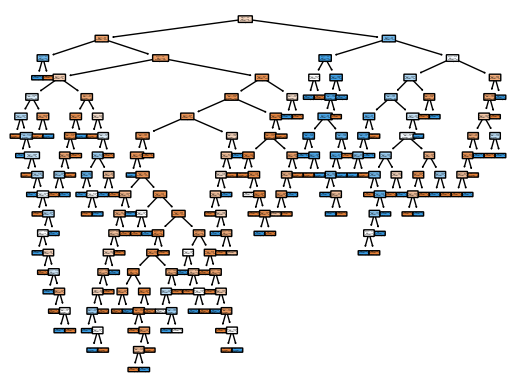

In [136]:
# train decision tree
decision_tree = DecisionTreeClassifier(max_depth=None, random_state=42)
decision_tree.fit(X_train, y_train)


# plot tree
fig = plt.figure()
tree.plot_tree(decision_tree, rounded = True, proportion = False, precision = 2, filled = True)

# display tree
fig.savefig('titanic_decision_tree.png')

Compute the models accuracy on the development set

In [137]:
print("Performance of model on development set:", decision_tree.score(X_dev, y_dev))
print("At depth:", decision_tree.tree_.max_depth)

Performance of model on development set: 0.7605633802816901
At depth: 18


Tis model correctly predicts approximately 76.06% of the instances in the development set.
The depth is 18 which suggests that the model is highly complex and may be prone to overfitting.

Try building your model with different value of max_depth (2-10)

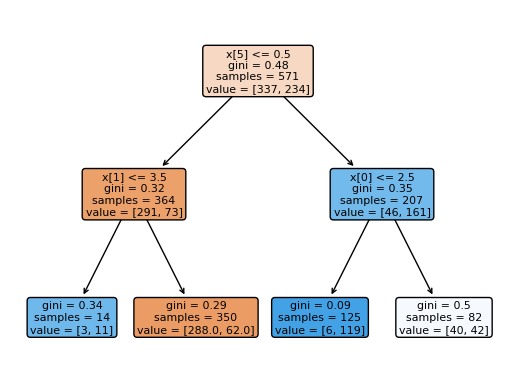

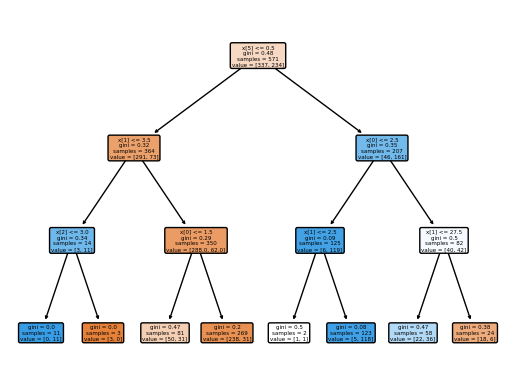

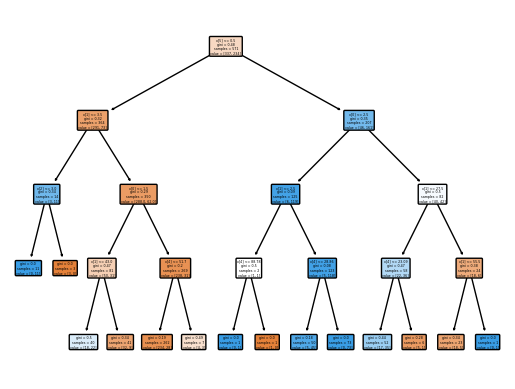

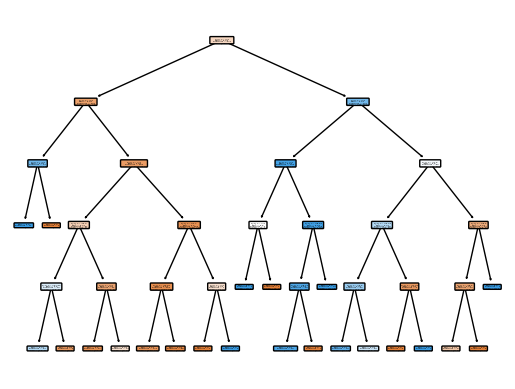

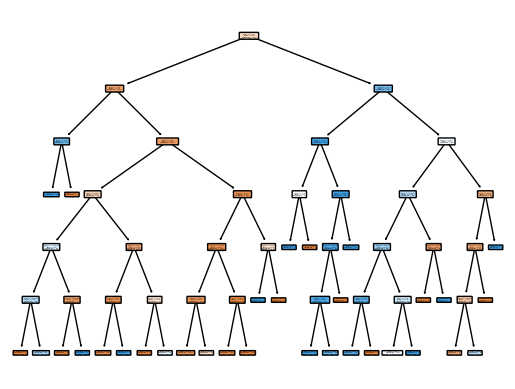

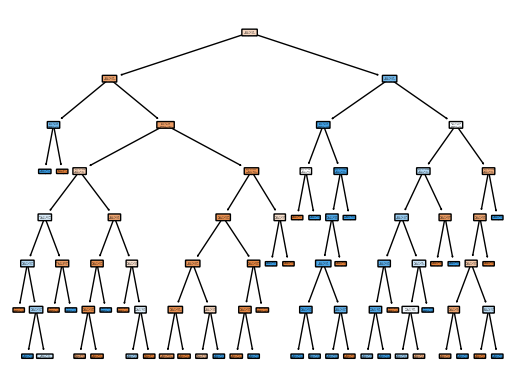

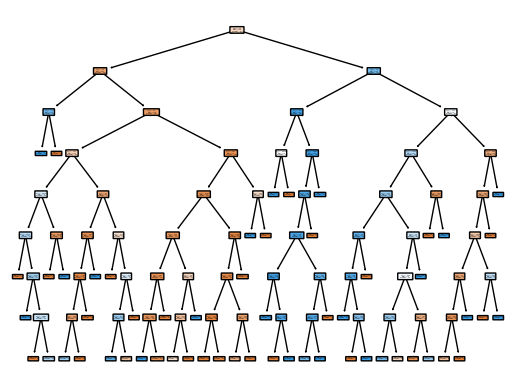

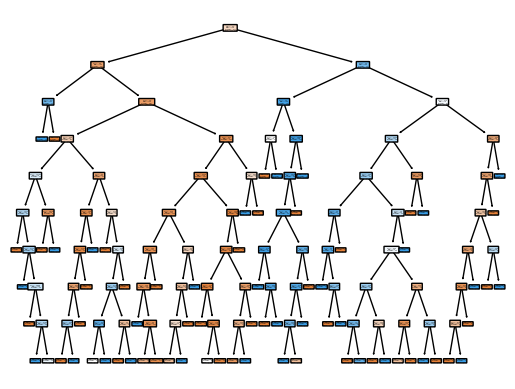

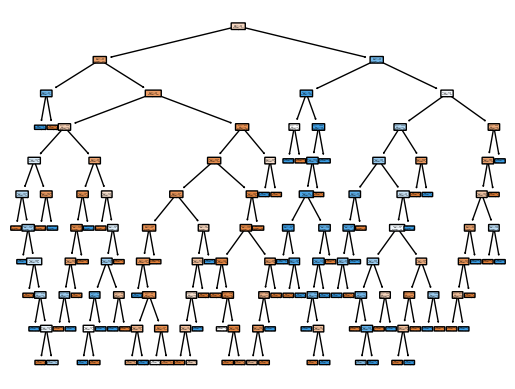

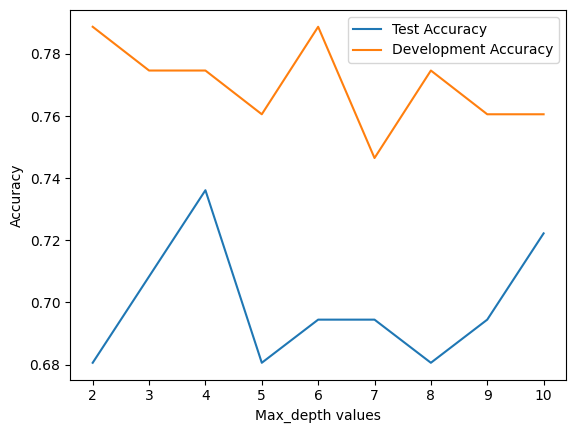

In [138]:
# create the range of pruning from 2-10 for max depth
pruned_depths = range(2,11)

test_scores = [] 
dev_scores = []
for d in pruned_depths:
  clf = DecisionTreeClassifier(max_depth=d, random_state=42)
  clf.fit(X_train, y_train) # train the decision tree
  fig = plt.figure() # plot the tree for each max_depth
  tree.plot_tree(clf, rounded = True, proportion = False, precision = 2, filled = True)
  test_score = clf.score(X_test, y_test) # find the accuracy of the decision tree to the test data
  test_scores.append(test_score) # store the score in trained_scores
  dev_score = clf.score(X_dev, y_dev) # find the accuracy of the decision tree to the development data
  dev_scores.append(dev_score) # store the score in development_scores

fig, ax = plt.subplots() # plot the scores for the training and development data on the same graph
ax.plot(pruned_depths, test_scores, label='Test Accuracy')
ax.plot(pruned_depths, dev_scores, label='Development Accuracy')
plt.xlabel("Max_depth values")
plt.ylabel("Accuracy")
ax.xaxis.set_ticks(pruned_depths)
ax.legend()

This graph shows an unusual outcome. It suggests that there was no consistency between the accuracy of the tree on the two sets with the increase in max depth. The accuracy was best for the development set at a max depth value of 2, and it was best for the test set at a max depth of 4. Just from eyeballing the graph I would suggest that the max_depth value of 4 is the optimum output for the two sets of data.

It appears that the accuracy of the model on the test data is not as good as on the development data. But the accuracy is still above 68% at a max_depth of 2 which suggests it is still a good fit.

Task 21:

Create a bagged, random forest, and boosted tree for the Titanic data set in the same way that you created a regular classification tree.

In [139]:
# fit a bagged tree
bagged_tree = BaggingClassifier(estimator=decision_tree, n_estimators=100, random_state=42)
bagged_tree.fit(X_train, y_train)

# fit a random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# fit a boosted tree
boosted_tree = GradientBoostingClassifier(n_estimators=100, random_state=42)
boosted_tree.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

From the random forest model, determine which of the features is the one that contributes the most to predicting whether a passenger survives or not

In [140]:
feature_imp = pd.Series(random_forest.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp

Age           0.274850
Fare          0.234090
Sex_male      0.163518
Sex_female    0.134152
Pclass        0.085532
SibSp         0.041036
Parch         0.036580
Embarked_C    0.015158
Embarked_S    0.011010
Embarked_Q    0.004075
dtype: float64

Looking at the feature importances it appears that Age is the feature that contributes the most to predicting whether a passenger survives or not.

Tune the parameters n_estimators and max_depth for the random forest. I have decided to do this using GridSearchCV

In [141]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30]  # Maximum depth of the trees
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on the development set
best_rf = grid_search.best_estimator_
best_rf_score = best_rf.score(X_dev, y_dev)
print("Performance of the best Random Forest model on development set:", best_rf_score)

# Feature importance of the best model
feature_importances = best_rf.feature_importances_
feature_imp = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

# Display the feature importances
print(feature_imp)

Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Best Score: 0.8248665141113654
Performance of the best Random Forest model on development set: 0.8028169014084507
Age           0.236113
Fare          0.206196
Sex_male      0.183519
Sex_female    0.164183
Pclass        0.095223
SibSp         0.043110
Parch         0.039947
Embarked_C    0.014621
Embarked_S    0.012560
Embarked_Q    0.004528
dtype: float64


Report the accuracy of all the models and report which model performed best, including the values for n_estimators and max_depth that the best model had.

I will apply the same methodology as I did for the random forest to the other models.

For the bagged tree I will use the RandomizedSearchCV:

In [142]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20, 30]
}

# Initialize RandomizedSearchCV for BaggingClassifier
random_search_bagging = RandomizedSearchCV(estimator=bagged_tree, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the training data
random_search_bagging.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for BaggingClassifier:", random_search_bagging.best_params_)
print("Best Score for BaggingClassifier:", random_search_bagging.best_score_)

# Evaluate the best model on the development set
best_bagging = random_search_bagging.best_estimator_
best_bagging_score = best_bagging.score(X_dev, y_dev)
print("Performance of the best Bagging model on development set:", best_bagging_score)

Best Parameters for BaggingClassifier: {'n_estimators': 200, 'estimator__max_depth': 10}
Best Score for BaggingClassifier: 0.8143096872616324
Performance of the best Bagging model on development set: 0.8028169014084507


For the boosted tree:

In [143]:
# Define the parameter grid for GradientBoostingClassifier
param_grid_boosting = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV for GradientBoostingClassifier
grid_search_boosting = GridSearchCV(estimator=boosted_tree, param_grid=param_grid_boosting, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_boosting.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for GradientBoostingClassifier:", grid_search_boosting.best_params_)
print("Best Score for GradientBoostingClassifier:", grid_search_boosting.best_score_)

Best Parameters for GradientBoostingClassifier: {'max_depth': 3, 'n_estimators': 100}
Best Score for GradientBoostingClassifier: 0.8353928299008391


The best scores for the three types of tree are as follows:

Bagged tree: 81.43% (n_estimator:200, max_depth:10)

Random forest: 82.49% (200, 10)

Boosted tree: 83.54% (100, 3)


These results suggest that the boosted tree is the best model for this dataset, with the highest score at the parameters of n_estimator: 100 and max_depth: 3.